<a href="https://colab.research.google.com/github/JonathanSum/fastbook/blob/master/60_medical_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://i.imgur.com/KwPP5Jt.jpg" width=300>

In [0]:
#default_exp medical.imaging

In [1]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   322  100   322    0     0   2875      0 --:--:-- --:--:-- --:--:--  2875
Updating fastai...
Done.


In [4]:
!git clone https://github.com/fastai/fastbook.git
!pip install -r /content/fastbook/requirements.txt

fatal: destination path 'fastbook' already exists and is not an empty directory.
     |████████████████████████████████| 184kB 5.1MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.0MB 19.6MB/s 
     |████████████████████████████████| 40kB 6.1MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 2.3MB 28.2MB/s 


In [0]:
from fastbook import utils

In [9]:
!pip install pydicom
!pip install kornia

     |████████████████████████████████| 143kB 4.8MB/s 


In [0]:
 ! pip install -q kaggle

In [37]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!mkdir '/content/data/happy_sugar_life'

In [0]:
# !kaggle datasets list
!kaggle competitions download -c rsna-intracranial-hemorrhage-detection -p /content/data/happy_sugar_life

In [50]:
t=get_files("/content/data/happy_sugar_life")
t[0]

Path('/content/data/happy_sugar_life/ID_000039fa0.dcm')

In [0]:
# path_inp = Path('../input')
# path = path_inp/'rsna-intracranial-hemorrhage-detection'
# path_trn = path/'stage_1_train_images'
# path_tst = path/'stage_1_test_images'
#../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_9d9cc6b01.dcm
path_inp = Path('../input')
path = path_inp/'rsna-intracranial-hemorrhage-detection'
path_trn = path/'/content/data/happy_sugar_life'
path_tst = path/'/content/data/happy_sugar_life'

In [0]:
!rm -r /content/train_png

In [58]:
!unzip /content/data/happy_sugar_life/stage_2_train.csv.zip
!mv /content/stage_2_train.csv /content/data/happy_sugar_life

Archive:  /content/data/happy_sugar_life/stage_2_train.csv.zip
replace stage_2_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stage_2_train.csv       


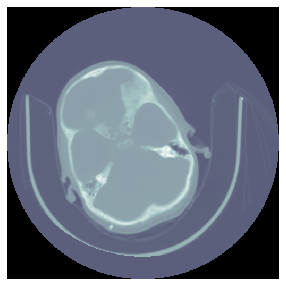

In [129]:
fname = path_trn/'ID_000178e76.dcm'
dcm = fname.dcmread()
dcm.show(scale=False)

# Medical Imaging

> Helpers for working with DICOM files

In [0]:
#export 
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.data.transforms import *

import pydicom,kornia,skimage
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
from PIL import Image

try:
    import cv2
    cv2.setNumThreads(0)
except: pass

In [0]:
from nbdev.showdoc import *
matplotlib.rcParams['image.cmap'] = 'bone'

In [0]:
#export
_all_ = ['DcmDataset', 'DcmTag', 'DcmMultiValue', 'dcmread', 'get_dicom_files']

## Patching

In [0]:
#export
def get_dicom_files(path, recurse=True, folders=None):
    "Get dicom files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=[".dcm"], recurse=recurse, folders=folders)

In [0]:
#export
@patch
def dcmread(self:Path, force = False):
    return pydicom.dcmread(str(self), force)

In [0]:
# #export
# @patch
# def png16read(self:Path): return array(Image.open(self), dtype=np.uint16)

In [0]:
TEST_DCM = Path('/content/data/happy_sugar_life/ID_000000e27.dcm')
dcm = TEST_DCM.dcmread()

In [0]:
#export
@patch_property
def pixels(self:DcmDataset):
    "`pixel_array` as a tensor"
    return tensor(self.pixel_array.astype(np.float32))

In [0]:
#export
@patch_property
def scaled_px(self:DcmDataset):
    "`pixels` scaled by `RescaleSlope` and `RescaleIntercept`"
    img = self.pixels
    return img if self.Modality == "CR" else img * self.RescaleSlope + self.RescaleIntercept

In [0]:
#export
def array_freqhist_bins(self, n_bins=100):
    "A numpy based function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = np.sort(self.flatten())
    t = np.array([0.001])
    t = np.append(t, np.arange(n_bins)/n_bins+(1/2/n_bins))
    t = np.append(t, 0.999)
    t = (len(imsd)*t+0.5).astype(np.int)
    return np.unique(imsd[t])

In [0]:
#export
@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

In [0]:
#export
@patch
def hist_scaled_pt(self:Tensor, brks=None):
    # Pytorch-only version - switch to this if/when interp_1d can be optimized
    if brks is None: brks = self.freqhist_bins()
    brks = brks.to(self.device)
    ys = torch.linspace(0., 1., len(brks)).to(self.device)
    return self.flatten().interp_1d(brks, ys).reshape(self.shape).clamp(0.,1.)

In [0]:
#export
@patch
def hist_scaled(self:Tensor, brks=None):
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)

In [0]:
#export
@patch
def hist_scaled(self:DcmDataset, brks=None, min_px=None, max_px=None):
    px = self.scaled_px
    if min_px is not None: px[px<min_px] = min_px
    if max_px is not None: px[px>max_px] = max_px
    return px.hist_scaled(brks=brks)

In [0]:
#export
@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

In [0]:
#export
@patch
def windowed(self:DcmDataset, w, l):
    return self.scaled_px.windowed(w,l)

In [0]:
#export
# From https://radiopaedia.org/articles/windowing-ct
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400)
)

In [0]:
#export
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

In [0]:
#export
class PILCTScan(PILBase): _open_args,_tensor_cls,_show_args = {},TensorCTScan,TensorCTScan._show_args

In [0]:
#export
@patch
@delegates(show_image)
def show(self:DcmDataset, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    show_image(px, cmap=cmap, **kwargs)

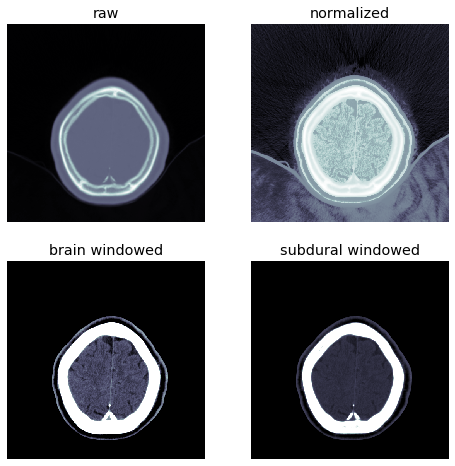

In [150]:
scales = False, True, dicom_windows.brain, dicom_windows.subdural
titles = 'raw','normalized','brain windowed','subdural windowed'
for s,a,t in zip(scales, subplots(2,2,imsize=4)[1].flat, titles):
    dcm.show(scale=s, ax=a, title=t)

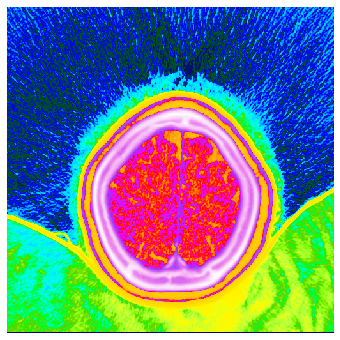

In [151]:
dcm.show(cmap=plt.cm.gist_ncar, figsize=(6,6))

In [0]:
#export
@patch
def pct_in_window(dcm:DcmDataset, w, l):
    "% of pixels in the window `(w,l)`"
    px = dcm.scaled_px
    return ((px > l-w//2) & (px < l+w//2)).float().mean().item()

In [153]:
dcm.pct_in_window(*dicom_windows.brain)

0.17197036743164062

In [0]:
#export
def uniform_blur2d(x,s):
    w = x.new_ones(1,1,1,s)/s
    # Factor 2d conv into 2 1d convs
    x = unsqueeze(x, dim=0, n=4-x.dim())
    r = (F.conv2d(x, w, padding=s//2))
    r = (F.conv2d(r, w.transpose(-1,-2), padding=s//2)).cpu()[:,0]
    return r.squeeze()

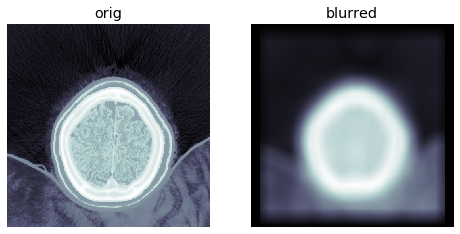

In [155]:
ims = dcm.hist_scaled(), uniform_blur2d(dcm.hist_scaled(),50)
show_images(ims, titles=('orig', 'blurred'))

In [0]:
#export
def gauss_blur2d(x,s):
    s2 = int(s/4)*2+1
    x2 = unsqueeze(x, dim=0, n=4-x.dim())
    res = kornia.filters.gaussian_blur2d(x2, (s2,s2), (s,s), 'replicate')
    return res.squeeze()

In [0]:
#export
@patch
def mask_from_blur(x:Tensor, window, sigma=0.3, thresh=0.05, remove_max=True):
    p = x.windowed(*window)
    if remove_max: p[p==1] = 0
    return gauss_blur2d(p, s=sigma*x.shape[-1])>thresh

In [0]:
#export
@patch
def mask_from_blur(x:DcmDataset, window, sigma=0.3, thresh=0.05, remove_max=True):
    return to_device(x.scaled_px).mask_from_blur(window, sigma, thresh, remove_max=remove_max)

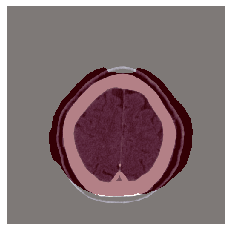

In [159]:
mask = dcm.mask_from_blur(dicom_windows.brain)
wind = dcm.windowed(*dicom_windows.brain)

_,ax = subplots(1,1)
show_image(wind, ax=ax[0])
show_image(mask, alpha=0.5, cmap=plt.cm.Reds, ax=ax[0]);

In [0]:
#export
def _px_bounds(x, dim):
    c = x.sum(dim).nonzero().cpu()
    idxs,vals = torch.unique(c[:,0],return_counts=True)
    vs = torch.split_with_sizes(c[:,1],tuple(vals))
    d = {k.item():v for k,v in zip(idxs,vs)}
    default_u = tensor([0,x.shape[-1]-1])
    b = [d.get(o,default_u) for o in range(x.shape[0])]
    b = [tensor([o.min(),o.max()]) for o in b]
    return torch.stack(b)

In [0]:
#export
def mask2bbox(mask):
    no_batch = mask.dim()==2
    if no_batch: mask = mask[None]
    bb1 = _px_bounds(mask,-1).t()
    bb2 = _px_bounds(mask,-2).t()
    res = torch.stack([bb1,bb2],dim=1).to(mask.device)
    return res[...,0] if no_batch else res

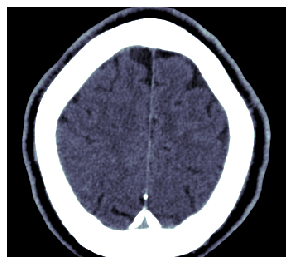

In [162]:
bbs = mask2bbox(mask)
lo,hi = bbs
show_image(wind[lo[0]:hi[0],lo[1]:hi[1]]);

In [0]:
#export
def _bbs2sizes(crops, init_sz, use_square=True):
    bb = crops.flip(1)
    szs = (bb[1]-bb[0])
    if use_square: szs = szs.max(0)[0][None].repeat((2,1))
    overs = (szs+bb[0])>init_sz
    bb[0][overs] = init_sz-szs[overs]
    lows = (bb[0]/float(init_sz))
    return lows,szs/float(init_sz)

In [0]:
#export
def crop_resize(x, crops, new_sz):
    # NB assumes square inputs. Not tested for non-square anythings!
    bs = x.shape[0]
    lows,szs = _bbs2sizes(crops, x.shape[-1])
    if not isinstance(new_sz,(list,tuple)): new_sz = (new_sz,new_sz)
    id_mat = tensor([[1.,0,0],[0,1,0]])[None].repeat((bs,1,1)).to(x.device)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        sp = F.affine_grid(id_mat, (bs,1,*new_sz))+1.
        grid = sp*unsqueeze(szs.t(),1,n=2)+unsqueeze(lows.t()*2.,1,n=2)
        return F.grid_sample(x.unsqueeze(1), grid-1)

torch.Size([1, 128, 128])

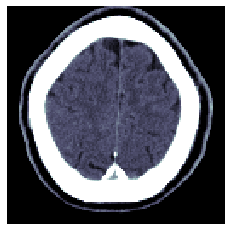

In [165]:
px256 = crop_resize(to_device(wind[None]), bbs[...,None], 128)[0]
show_image(px256)
px256.shape

In [0]:
#export
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

In [0]:
#export
@patch
def to_nchan(x:DcmDataset, wins, bins=None):
    return x.scaled_px.to_nchan(wins, bins)

In [0]:
#export
@patch
def to_3chan(x:Tensor, win1, win2, bins=None):
    return x.to_nchan([win1,win2],bins=bins)

In [0]:
#export
@patch
def to_3chan(x:DcmDataset, win1, win2, bins=None):
    return x.scaled_px.to_3chan(win1, win2, bins)

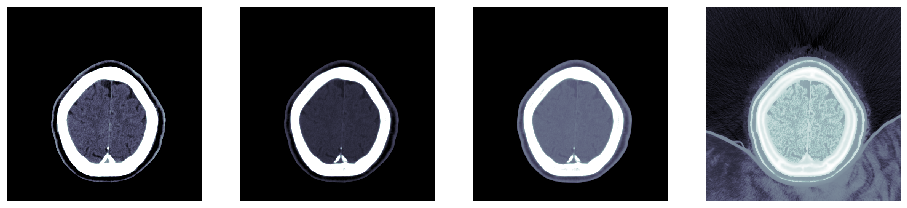

In [170]:
show_images(dcm.to_nchan([dicom_windows.brain,dicom_windows.subdural,dicom_windows.abdomen_soft]))

In [0]:
#export
@patch
def save_jpg(x:(Tensor,DcmDataset), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

In [0]:
#export
@patch
def to_uint16(x:(Tensor,DcmDataset), bins=None):
    d = x.hist_scaled(bins).clamp(0,1) * 2**16
    return d.numpy().astype(np.uint16)

In [0]:
#export
@patch
def save_tif16(x:(Tensor,DcmDataset), path, bins=None, compress=True):
    fn = Path(path).with_suffix('.tif')
    Image.fromarray(x.to_uint16(bins)).save(str(fn), compression='tiff_deflate' if compress else None)

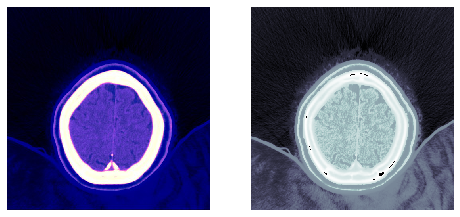

In [174]:
_,axs=subplots(1,2)
with tempfile.TemporaryDirectory() as f:
    f = Path(f)
    dcm.save_jpg(f/'test.jpg', [dicom_windows.brain,dicom_windows.subdural])
    show_image(Image.open(f/'test.jpg'), ax=axs[0])
    dcm.save_tif16(f/'test.tif')
    show_image(Image.open(str(f/'test.tif')), ax=axs[1]);

In [0]:
#export
@patch
def set_pixels(self:DcmDataset, px):
    self.PixelData = px.tobytes()
    self.Rows,self.Columns = px.shape
DcmDataset.pixel_array = property(DcmDataset.pixel_array.fget, set_pixels)

In [0]:
#export
@patch
def zoom(self:DcmDataset, ratio):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        self.pixel_array = ndimage.zoom(self.pixel_array, ratio)

In [0]:
#export
@patch
def zoom_to(self:DcmDataset, sz):
    if not isinstance(sz,(list,tuple)): sz=(sz,sz)
    rows,cols = sz
    self.zoom((rows/self.Rows,cols/self.Columns))

In [0]:
#export
@patch_property
def shape(self:DcmDataset): return self.Rows,self.Columns

In [0]:
dcm2 = TEST_DCM.dcmread()
dcm2.zoom_to(90)
test_eq(dcm2.shape, (90,90))

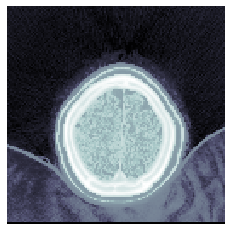

In [180]:
dcm2 = TEST_DCM.dcmread()
dcm2.zoom(0.25)
dcm2.show()

In [0]:
#export
def _cast_dicom_special(x):
    cls = type(x)
    if not cls.__module__.startswith('pydicom'): return x
    if cls.__base__ == object: return x
    return cls.__base__(x)

def _split_elem(res,k,v):
    if not isinstance(v,DcmMultiValue): return
    res[f'Multi{k}'] = 1
    for i,o in enumerate(v): res[f'{k}{"" if i==0 else i}']=o

In [0]:
#export
@patch
def as_dict(self:DcmDataset, px_summ=True, window=dicom_windows.brain):
    pxdata = (0x7fe0,0x0010)
    vals = [self[o] for o in self.keys() if o != pxdata]
    its = [(v.keyword,v.value) for v in vals]
    res = dict(its)
    res['fname'] = self.filename
    for k,v in its: _split_elem(res,k,v)
    if not px_summ: return res
    stats = 'min','max','mean','std'
    try:
        pxs = self.pixel_array
        for f in stats: res['img_'+f] = getattr(pxs,f)()
        res['img_pct_window'] = self.pct_in_window(*window)
    except Exception as e:
        for f in stats: res['img_'+f] = 0
        print(res,e)
    for k in res: res[k] = _cast_dicom_special(res[k])
    return res

In [0]:
#export
def _dcm2dict(fn, **kwargs): return fn.dcmread().as_dict(**kwargs)

In [0]:
#export
@delegates(parallel)
def _from_dicoms(cls, fns, n_workers=0, **kwargs):
    return pd.DataFrame(parallel(_dcm2dict, fns, n_workers=n_workers, **kwargs))
pd.DataFrame.from_dicoms = classmethod(_from_dicoms)

## Export -

In [0]:
#hide
from nbdev.export import notebook2script
notebook2script()